In [1]:
%load_ext autoreload
%autoreload 2

import argparse
import os
from pathlib import Path

import numpy as np
import pandas as pd
import src.BertClassifier as BertClassifier
import src.utils as utils
import torch
import yaml
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

import wandb

device = utils.get_device()
config_path = "loo/classifier.yaml"
epochs = 10
num_training_examples = 1000

with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({"epochs": epochs, "num_training_examples": num_training_examples})

# Create datasets
train_dataset = create_train_sst2(
    device,
    num_samples=config["num_training_examples"],
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
)

test_dataset = create_test_sst2(
    device,
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10476.75it/s]


## Train Model on Full Data

In [2]:
train_dataloader = DataLoader(
    train_dataset, batch_size=config["batch_size"], shuffle=True
)

# Create classifcation model
full_model = BertClassifier.create_bert_classifier(
    config["bert_model_name"],
    classifier_type=config["classifier_type"],
    classifier_hidden_size=config["classifier_hidden_size"],
    classifier_drop_out=config["classifier_drop_out"],
    freeze_bert=True,
    random_state=42,
)
full_model.classifier.load_state_dict(
    torch.load("loo_10k/run_0/init_classifier_params.pt")
)
# torch.save(model.classifier.state_dict(), 'classifier_params.pt')

optimizer = Adam(full_model.classifier.parameters(), lr=config["learning_rate"])
loss_fn = torch.nn.CrossEntropyLoss()

run = wandb.init(project="LOO-test", tags=["full"], config=config)

timings = utils.train(
    config=config,
    model=full_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    val_dataloader=None,
)

fdf, test_loss, test_acc = utils.evaluate_loss_df(full_model, test_dataloader)
wandb.summary["test/loss"] = test_loss
wandb.summary["test/accuracy"] = test_acc
wandb.finish()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: patcao. Use `wandb login --relogin` to force relogin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.79batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▇▇▇▇████
train/batch_loss,█▇▇▇▆▆▅▅▄▅▆▃▄▂▂▆▆▆▅▄▂▃▅▃▄▄▅▃▂▃▃▅▄▄▂▄▂▂▃▁
train/loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test/accuracy,81.76606
test/loss,0.4104
train/accuracy,87.79762
train/batch_loss,0.08084
train/loss,0.32155


In [ ]:
# Compute loss for each test point
# fdf, test_loss, test_acc = utils.evaluate_loss_df(full_model, test_dataloader)
# fdf

In [3]:
fdf[fdf.test_guid == 869]

,test_guid,logits,pred,label,loss
869,869,"[-0.7313803, 0.27960566]",1,0,1.321305


In [45]:
fdf[fdf.test_guid == 869]

,test_guid,label,pred,loss
869,869,0,1,0.986901


## Compute Saliency Map

In [58]:
from src.saliency import compute_saliency_map

In [59]:
%%time
m = compute_saliency_map(full_model, test_dataset)

CPU times: user 11.8 s, sys: 391 ms, total: 12.2 s
Wall time: 15.2 s


In [61]:
m[560]

[('[CLS]', 0.018220345),
 ('do', 0.062947236),
 ('n', 0.034391075),
 ("'", 0.06174885),
 ('t', -0.04071759),
 ('be', -0.0002947131),
 ('fooled', -0.048391078),
 ('by', -0.027427686),
 ('the', -0.06221382),
 ('impressive', 0.067453265),
 ('cast', 0.088975295),
 ('list', 0.036550414),
 ('-', -0.054100297),
 ('eye', -0.0916301),
 ('see', -0.007062814),
 ('you', 0.036172513),
 ('is', -0.16360521),
 ('pure', 0.002578981),
 ('junk', -0.011266417),
 ('.', -0.02096015),
 ('[SEP]', 0.06329211)]

In [53]:
import src.datasets as datasets
datasets.get_train_example(0).sentence.squeeze()

'hide new secretions from the parental units '

## Compute Input Influence

In [58]:
import src.influence as inf_utils

test_guid = 560
param_infl = list(full_model.classifier.parameters())
infl = inf_utils.compute_input_influence(
    full_model=full_model,
    test_guid=test_guid,
    param_influence=param_infl,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    lissa_r=2,
    lissa_depth=1,
    damping=5e-3,
    scale=100,
    training_indices=[0],
)

LiSSA reps: 2 and num_iterations: 800
Recursion at depth 0: norm is 6.080253
Recursion at depth 200: norm is 100.738991
Recursion at depth 400: norm is 133.316620
Recursion at depth 600: norm is 144.424957
Recursion at depth 799: norm is 149.191589
Recursion at depth 0: norm is 6.149002
Recursion at depth 200: norm is 100.389175
Recursion at depth 400: norm is 133.715179
Recursion at depth 600: norm is 145.010590
Recursion at depth 799: norm is 148.986282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.68it/s]


In [64]:
for token_idx in range(64):
    token_infl = infl[0][token_idx]
    print(np.linalg.norm(token_infl))

1.3271688431842823
3.0832113640498804
1.6184760165347525
1.9189202851416571
1.2951182913815786
0.9447649688890077
1.1850208067471606
1.954149161662421
1.8627801382009113
0.9770001748609257
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [81]:

sent = datasets.get_train_example(1).sentence.squeeze()

In [84]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [87]:
input_ids = tokenizer.encode_plus(text=sent, max_length=64, padding='max_length')['input_ids']

In [97]:
iter(torch.tensor(input_ids))

In [102]:
d = datasets.get_tokens_from_ids(input_ids)

In [113]:
d[:10]

['[CLS]', 'contains', 'no', 'wit', ',', 'only', 'labor', '##ed', 'gag', '##s']

In [104]:
['a', 'b', 'c']

['a', 'b', 'c']

In [71]:
import src.datasets as datasets

train_dataset.tensors[1][0]

tensor([  101,  5342,  2047,  3595,  8496,  2013,  1996, 18643,  3197,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0], device='cuda:0')

In [4]:
from tqdm import tqdm

for i, batch in enumerate(tqdm([1,2,3], unit='batch')):
    print(f"{i}: {batch}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33376.42batch/s]

0: 1
1: 2
2: 3


## Train Multiple LOO Models

In [171]:
%%time
from torch.utils.data import Dataset, TensorDataset

loss_fn = torch.nn.CrossEntropyLoss()
loo_dfs = []

for loo_guid in range(0, 5):
    loo_dataset = create_loo_dataset(train_dataset, loo_guid)
    loo_train_dataloader = DataLoader(
        loo_dataset, batch_size=config["batch_size"], shuffle=True
    )

    # Create classifcation model
    loo_model = BertClassifier.create_bert_classifier(
        config["bert_model_name"],
        classifier_type=config["classifier_type"],
        classifier_hidden_size=config["classifier_hidden_size"],
        classifier_drop_out=config["classifier_drop_out"],
        freeze_bert=True,
        random_state=42,
    )

    optimizer = Adam(loo_model.classifier.parameters(), lr=config["learning_rate"])
    run = wandb.init(project="LOO-test", tags=["full"], config=config)

    timings = utils.train(
        config=config,
        model=loo_model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        train_dataloader=loo_train_dataloader,
        val_dataloader=None,
    )

    # Compute loss for each test point
    df, test_loss, test_acc = utils.evaluate_loss_df(loo_model, test_dataloader)
    df["loo_guid"] = loo_guid
    loo_dfs.append(df)

    wandb.summary["test/loss"] = test_loss
    wandb.summary["test/accuracy"] = test_acc
    wandb.finish()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▆▇▇▇▇███
train/batch_loss,█▇▆▆▅▂▄▃▄▂▂▂█▂▅▁▄▄▂▁▂▄▃▃▄▄▄▂▄▂▃▃▆▁▅▁▆▄▂▅
train/loss,█▃▃▃▃▂▂▁▁▁
epoch,10
train/accuracy,85.058
train/batch_loss,0.10022
train/loss,0.3463


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:21<00:00, 28.57batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▆▇▇▇▇███
train/batch_loss,█▇▆▆▅▂▄▃▄▂▂▂█▂▅▁▄▄▂▁▂▄▃▃▄▄▄▂▄▂▃▃▆▁▅▁▆▄▂▅
train/loss,█▃▃▃▃▂▂▁▁▁
epoch,10
test/accuracy,82.91284
test/loss,0.38059
train/accuracy,85.058
train/batch_loss,0.10022
train/loss,0.3463


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:23<00:00, 26.92batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▆▇▇▇▇███
train/batch_loss,█▇▆▆▅▂▄▃▄▂▂▂█▂▅▁▄▄▂▁▂▄▃▃▄▄▄▂▄▂▃▃▆▁▆▁▆▄▂▅
train/loss,█▃▃▃▃▂▂▁▁▁
epoch,10
test/accuracy,82.91284
test/loss,0.38077
train/accuracy,85.078
train/batch_loss,0.10031
train/loss,0.34636


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:23<00:00, 26.93batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▆▇▇▇▇███
train/batch_loss,█▇▆▆▅▂▄▃▄▂▂▂█▂▅▁▄▄▂▁▂▄▃▃▄▄▄▂▄▂▃▃▆▁▆▁▆▄▂▅
train/loss,█▃▃▃▃▂▂▁▁▁
epoch,10
test/accuracy,82.91284
test/loss,0.38078
train/accuracy,85.088
train/batch_loss,0.10033
train/loss,0.34636


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:23<00:00, 26.46batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▆▇▇▇▇███
train/batch_loss,█▇▆▆▅▂▄▃▄▂▂▂█▂▅▁▄▄▂▁▂▄▃▃▃▄▄▂▄▂▃▃▆▁▅▁▆▄▂▅
train/loss,█▃▃▃▃▂▂▁▁▁
epoch,10
test/accuracy,82.91284
test/loss,0.38062
train/accuracy,85.088
train/batch_loss,0.10008
train/loss,0.3461


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:23<00:00, 27.15batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▆▇▇▇▇███
train/batch_loss,█▇▆▆▅▂▄▃▄▂▂▂█▂▅▁▄▄▂▁▂▄▃▃▄▄▄▂▄▂▃▃▆▁▆▁▆▄▂▅
train/loss,█▃▃▃▃▂▂▁▁▁
epoch,10
test/accuracy,82.91284
test/loss,0.38092
train/accuracy,85.068
train/batch_loss,0.10075
train/loss,0.34618


CPU times: user 19min 2s, sys: 12.7 s, total: 19min 14s
Wall time: 20min 36s


## Compute Loss Influence

In [172]:
import src.influence as inf_utils

test_guid = 560
param_infl = list(full_model.classifier.parameters())
infl = inf_utils.compute_influence(
    full_model=full_model,
    test_guid=test_guid,
    param_influence=param_infl,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    lissa_r=1,
    lissa_depth=0.25,
    damping=5e-3,
    scale=100,
    # training_indices=list(range(15)),
)

LiSSA reps: 1 and num_iterations: 2500
Recursion at depth 0: norm is 5.997543
Recursion at depth 200: norm is 100.309464
Recursion at depth 400: norm is 132.143036
Recursion at depth 600: norm is 143.141006
Recursion at depth 800: norm is 147.662994
Recursion at depth 1000: norm is 148.352600
Recursion at depth 1200: norm is 148.784302
Recursion at depth 1400: norm is 149.818939
Recursion at depth 1600: norm is 148.976807
Recursion at depth 1800: norm is 149.960175
Recursion at depth 2000: norm is 149.547577
Recursion at depth 2200: norm is 150.168030
Recursion at depth 2400: norm is 149.483978
Recursion at depth 2499: norm is 148.560623


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:17<00:00, 129.83it/s]


## Compare IF and LOO

In [179]:
fdf[fdf.test_guid == test_guid].loss.squeeze()

0.23130053281784058

In [1]:
# Load Losses from File
# ldf = pd.read_csv("loo_10k/all_loo_losses.csv")
ldf = pd.concat(loo_dfs, axis=0)

ldf = ldf[ldf.test_guid == test_guid]
ldf["loss_diff"] = ldf["loss"] - fdf[fdf.test_guid == test_guid].loss.squeeze()
ldf["if_diff"] = (-100.0 / len(train_dataset)) * infl[: len(ldf)]
ldf["if_diff2"] = (-1000.0 / len(train_dataset)) * influences[: len(ldf)]
ldf

NameError: name 'pd' is not defined

In [185]:
print(ldf[["loss_diff", "if_diff", "if_diff2"]].corr())
ldf[["loss_diff", "if_diff"]]

           loss_diff   if_diff  if_diff2
loss_diff   1.000000 -0.190201 -0.323901
if_diff    -0.190201  1.000000  0.952443
if_diff2   -0.323901  0.952443  1.000000


,loss_diff,if_diff
560,0.030185,-0.007012
560,0.030401,-0.000333
560,0.030469,0.000012
560,0.032457,-0.008813
560,0.032968,-0.001175


<Axes: xlabel='loss_diff', ylabel='if_diff'>

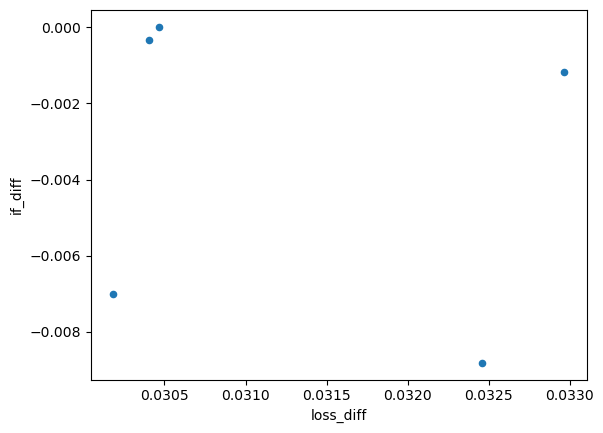

In [186]:
ldf[["loss_diff", "if_diff"]].plot.scatter("loss_diff", "if_diff")

## Torch Influence

In [174]:
import copy

from src.torch_influence import BaseObjective
from src.torch_influence.modules import CGInfluenceModule, LiSSAInfluenceModule


class BinClassObjective(BaseObjective):
    def train_outputs(self, model, batch):
        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        return model(b_input_ids, b_attn_mask)

    def train_loss_on_outputs(self, outputs, batch):
        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        loss_fn = torch.nn.CrossEntropyLoss()
        return loss_fn(outputs, b_labels)

    def train_regularization(self, params):
        return 0

    def test_loss(self, model, params, batch):
        loss_fn = torch.nn.CrossEntropyLoss()

        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        outputs = model(b_input_ids, b_attn_mask)

        return loss_fn(outputs, b_labels)


infl_model = BertClassifier.create_bert_classifier(
    config["bert_model_name"],
    classifier_type=config["classifier_type"],
    classifier_hidden_size=config["classifier_hidden_size"],
    classifier_drop_out=config["classifier_drop_out"],
    freeze_bert=True,
    random_state=42,
)
infl_model.load_state_dict(copy.deepcopy(full_model.state_dict()))

module = LiSSAInfluenceModule(
    model=infl_model,
    objective=BinClassObjective(),
    train_loader=DataLoader(train_dataset, batch_size=32),
    test_loader=DataLoader(test_dataset, batch_size=32),
    device=utils.get_device(),
    damp=0.001,
    repeat=1,
    depth=50,
    scale=1e4,
)

all_train_idxs = list(range(len(train_dataset)))
influences = module.influences(all_train_idxs, [test_guid])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1538

In [ ]:
----

In [ ]:
influences[:10]

## LOO Model

In [ ]:
loo_guid = 0

# Create train dataset
loo_dataset = create_loo_dataset(train_dataset, loo_guid)
train_dataloader = DataLoader(
    loo_dataset, batch_size=config["batch_size"], shuffle=True
)

# Create classifcation model
model = BertClassifier.create_bert_classifier(
    config["bert_model_name"],
    classifier_type=config["classifier_type"],
    classifier_hidden_size=config["classifier_hidden_size"],
    classifier_drop_out=config["classifier_drop_out"],
    freeze_bert=True,
    random_state=42,
)

optimizer = Adam(model.classifier.parameters(), lr=config["learning_rate"])
loss_fn = torch.nn.CrossEntropyLoss()


run = wandb.init(project="LOO-test", tags=["loo"], config=config)

timings = utils.train(
    config=config,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    val_dataloader=None,
)

test_loss, test_acc = utils.evaluate(model, test_dataloader)
wandb.summary["test/loss"] = test_loss
wandb.summary["test/accuracy"] = test_acc

In [ ]:
# Compute loss for each test point
df = utils.evaluate_loss_df(model, test_dataloader)
df

In [ ]:
--